### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** 27 апреля 2020, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 27 апреля, -4 балла после 08:30 4 мая, -6 баллов после 08:30 11 мая, -8 баллов после 08:30 18 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0220, Задание 3] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс DecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from functools import reduce
# !pip install tqdm -U
from tqdm.notebook import tqdm

In [102]:
class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=5, criterion='gini'):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        self.criterion = criterion
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        # Для последнего задания
        self.feature_importances_ = None
        self.criterion = criterion

        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева 
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
                
        self.tree = {0: [self.__class__.NON_LEAF_TYPE, -1, 0.0]}
        

    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]
    

    def __info(self, l_c, l_s, r_c, r_s, criterion):
        """
        Считаем меру неопределённости
        посредством критерия criterion
        по выборке (x, y)
        """

        if   criterion == 'misclass':
            return self.__misclass(l_c, l_s, r_c, r_s)
        
        elif criterion == 'gini':
            return self.__gini(l_c, l_s, r_c, r_s)
        
        elif criterion == 'entropy':
            return self.__entropy(l_c, l_s, r_c, r_s)
        
        else:
            raise RuntimeError("No such criterion as \'{}\'!".format(criterion))

            
            
    def __gini(self, l_c, l_s, r_c, r_s):#матрицы: NxKxF. N - число объектов
        l_s = l_s.astype('float')  # K - число классов, F - число признаков. r_c - общее количество 
        r_s = r_s.astype('float')  # справа, r_s количество справа по классам.
                                   # l_s: l_s - r_s = количество объектов слева по классам
                                   # l_c: l_c - r_c = общее количество объектов слева
        return ((r_s-l_s*(r_c/l_c))**2).sum(axis=1)/((l_c-r_c)*r_c).reshape(-1,1)
    
    def __entropy(self, l_c, l_s, r_c, r_s):
        return reduce(lambda ans,x:ans+(x[0]*np.log(x[0]/x[1]+0.000000000001)).sum(axis=1),
                      [[l_s-r_s,l_c-r_c],[r_s,r_c],[-l_s,-l_c]],0)/l_c
    def __misclass(self, l_c, l_s, r_c, r_s):
        return ((l_s-r_s)/(l_c-r_c)).max(axis=1)+(r_s/r_c).max(axis=1)-(l_s/l_c).max(axis=1)

    def __find_threshold(self, x, y):
        y_un=np.unique(y)
        LS=(y[...,np.newaxis]==y_un[np.newaxis]).sum(axis=0)
        if LS.max()==y.shape[0]:
            return [-1,-1]
        
        best_gain=0
        best_feature=best_th=-1
        
        rc=np.arange(1,y.shape[0])
        
        Y=y.shape[0]
        
        feature_ids=np.arange(x.shape[1])
        sorted_ids=x[:,feature_ids].argsort(axis=0)
        rs=(y[sorted_ids][:,np.newaxis]==y_un[np.newaxis,:,np.newaxis]).astype(int)
        for i in range(1,y.shape[0]):
                rs[i]+=rs[i-1]
        R=rs[-1]
        rs=rs[:-1]
        gain=self.__info(Y,R[np.newaxis],rc[...,np.newaxis,np.newaxis],rs, self.criterion)
        r=np.take_along_axis(x,sorted_ids,axis=0)
        gain*=r[:-1]!=r[1:]
        best_idx=gain.argmax()
        if gain.ravel()[best_idx] > 0:
            best_feature=feature_ids[best_idx%gain.shape[1]]
            best_th=x[sorted_ids.ravel()[best_idx],best_feature]
            self.feature_importances_[best_feature] += gain.ravel()[best_idx]
    
        return best_feature,best_th
        

    def __fit_node(self, x, y, node_id, depth):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с  айди 2 * node_id + 2
        """
        
        c_node = self.tree[node_id]
        
        y_len = y.shape[0]
        
        prob_distr = np.bincount(y, minlength=self.num_class,\
                                    weights=[1/y_len]*y_len)
        
        condition = (x.shape[0] <= self.min_samples_split) \
                        or np.isclose(np.max(prob_distr), 1.0) \
                            or (self.max_depth < depth)
        
        if condition:
            c_node[0] = self.__class__.LEAF_TYPE        
            c_node[1] = np.argmax(prob_distr)
            c_node[2] = prob_distr[c_node[1]]
        
        else:
            c_node[1], c_node[2] = self.__find_threshold(x, y)
            x_left, x_right, y_left, y_right = self.__div_samples(x, y, c_node[1], c_node[2])
            c_node[0] = self.__class__.NON_LEAF_TYPE
            self.tree[2*node_id+1] = [None, None, None]
            self.tree[2*node_id+2] = [None, None, None]  
            self.__fit_node(x_left,  y_left,  2*node_id+1, depth+1)
            self.__fit_node(x_right, y_right, 2*node_id+2, depth+1)

    
    def fit(self, x, y):        
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        self.num_class = np.unique(y).size
        self.feature_importances_= np.zeros(x.shape[1])
        self.__fit_node(np.asarray(x), np.asarray(y), 0, 0)
            

    def __predict_class(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]
        
        
    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in np.asarray(X)])

    
    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)

    
    def get_feature_importance(self):
        """
        Возвращает важность признаков
        """
        return {key: self.feature_importances_[key] for key in self.feature_importances_.argsort()[::-1]}

In [92]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2, criterion='gini')
clf = DecisionTreeClassifier(min_samples_split=2, criterion='gini')

In [93]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [94]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [95]:
accuracy_score(y_pred=clf.predict(X_test), y_true=y_test), accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

(0.8888888888888888, 0.8888888888888888)

## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine. 
Для этого используем numpy.

In [15]:
%timeit clf.fit(X_train, y_train)

883 µs ± 12.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [16]:
%timeit my_clf.fit(X_train, y_train)

6.02 ms ± 46.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match). 

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Данные и описания колонок лежат тут
https://cloud.mail.ru/public/8nHV/p6J7wY1y1/speed-dating-experiment/

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. 


In [22]:
df = pd.read_csv('Speed Dating Data.csv', encoding = "ISO-8859-1")

In [23]:
df.head()

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


In [24]:
df = df.drop(['id', 'idg', 'condtn', 'round', 'position', 'positin1',\
              'order', 'partner', 'age_o', 'race_o', 'pf_o_att',\
              'pf_o_sin', 'pf_o_int', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha',\
              'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o',\
              'amb_o', 'shar_o', 'like_o', 'prob_o','met_o'],\
              axis=1)\
       .dropna(subset=['age'])


In [25]:
df.loc[:, 'field_cd'] = df.loc[:, 'field_cd'].fillna(19)
df = df.drop(['field', 'undergra'], axis=1)
df.loc[:, 'mn_sat'] = df.loc[:, 'mn_sat'].str.replace(',', '').astype(np.float)
df.loc[:, 'tuition'] = df.loc[:, 'tuition'].str.replace(',', '').astype(np.float)

df.loc[:, 'income'] = df.loc[:, 'income'].str.replace(',', '').astype(np.float)
df.loc[:, 'income'] = df.loc[:, 'income'].fillna(-999)

In [26]:
df = df.dropna(subset=['imprelig', 'imprace'])
df = df.dropna(subset=['date'])
df.loc[:, 'career_c'] = df.loc[:, 'career_c'].fillna(18)

In [27]:
df = df.drop(['sports','tvsports','exercise','dining','museums','art','hiking','gaming',
       'clubbing','reading','tv','theater','movies','concerts','music','shopping','yoga'], axis=1)

In [28]:
df = df.drop(['expnum'], axis=1)

In [29]:
feat = ['iid', 'wave', 'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']
temp = df.drop_duplicates(subset=['iid', 'wave']).loc[:, feat]
temp.loc[:, 'totalsum'] = temp.iloc[:, 2:].sum(axis=1)
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr1_1',\
                            'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].sum(axis=1)
df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']] = \
        (df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']]\
        .T/df.loc[:, 'temp_totalsum'].T).T * 100

In [30]:
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].sum(axis=1)
df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']] = \
         (df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].\
         T/df.loc[:, 'temp_totalsum'].T).T * 100

In [31]:
df = df.drop(['wave'], axis=1)

In [32]:
df = df.drop(['temp_totalsum'], axis=1)
df_male = df.query('gender == 1').drop_duplicates(subset=['iid', 'pid'])\
                                 .drop(['gender'], axis=1)\
                                 .dropna()
df_female = df.query('gender == 0').drop_duplicates(subset=['iid'])\
                                   .drop(['gender', 'match', 'int_corr', 'samerace'], axis=1)\
                                   .dropna()        
df_female.columns = df_female.columns + '_f'

In [33]:
dd = {col: df[col].median() for col in df.columns if df[col].dtype == float}

In [34]:
df = df.dropna(axis=1, thresh=7500).fillna(dd)

In [35]:
df = pd.get_dummies(df)

Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности. 
Постройте графики зависимости точности на валидации от глубины дерева, от минимального числа объектов для сплита. 
Какой максимальной точности удалось достигнуть?

In [36]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2, max_depth=5, criterion='gini')
clf = DecisionTreeClassifier(min_samples_split=2, max_depth=5, criterion='gini')

In [37]:
X = df.drop(['match'], axis=1).to_numpy()
y = df.match.to_numpy()

In [38]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y)

In [39]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [40]:
clf_acc = accuracy_score(y_pred=clf.predict(X_val), y_true=y_val)
my_clf_acc = accuracy_score(y_pred=my_clf.predict(X_val), y_true=y_val)

print('Accuracy by sklearn tree: %.3f' % clf_acc)
print('Accuracy by custom  tree: %.3f' % my_clf_acc)

Accuracy by sklearn tree: 0.861
Accuracy by custom  tree: 0.852


In [183]:
search_params = {'max_depth': range(1,10),\
                 'min_sample_split': np.logspace(1,5,10,base=4),\
                 'criterion': ['gini', 'entropy']}# , 'misclass']}

In [184]:
all_params = \
    [[depth, int(sample), crit] for depth in search_params['max_depth']\
                           for sample in search_params['min_sample_split']\
                           for crit in search_params['criterion']]

print("Общее кол-во сочетаний параметров для перебора:", len(all_params))

Общее кол-во сочетаний параметров для перебора: 180


In [185]:
folder = KFold(n_splits=2, shuffle=True)

def get_score(params, X, y, metric=accuracy_score):
    
    my_scores = []    
    my_estimator = MyDecisionTreeClassifier(max_depth=int(params[0]),\
                                            min_samples_split=int(params[1]),\
                                            criterion=params[2])

    sk_scores = []        
    sk_estimator = DecisionTreeClassifier(max_depth=int(params[0]),\
                                          min_samples_split=int(params[1]),\
                                          criterion=params[2])
    
    for train_index, val_index in folder.split(X,y):
        
        my_estimator.fit(X[train_index], y[train_index])
        my_scores.append(accuracy_score(y_pred=my_estimator.predict(X[val_index]), y_true=y[val_index]))        
        sk_estimator.fit(X[train_index], y[train_index])
        sk_scores.append(accuracy_score(y_pred=sk_estimator.predict(X[val_index]), y_true=y[val_index]))        

    return [np.mean(my_scores), np.mean(sk_scores)]

In [186]:
indexes = np.arange(len(all_params))
np.random.shuffle(indexes)

In [187]:
table_of_results = pd.DataFrame()

my_history = []
sk_history = []
for index in tqdm(indexes):
    
    params = all_params[index]
    scores = get_score(params, X, y)
    
    tmp_frame = pd.DataFrame({'model_owner': 'custom',\
                              'max_depth': params[0],\
                              'min_sample_split': params[1],\
                              'criterion': params[2],\
                              'accuracy_score': [scores[0]]})
    table_of_results = table_of_results.append(tmp_frame)
    
    tmp_frame = pd.DataFrame({'model_owner': 'sklearn',\
                              'max_depth': params[0],\
                              'min_sample_split': params[1],\
                              'criterion': params[2],\
                              'accuracy_score': [scores[1]]})   
    table_of_results = table_of_results.append(tmp_frame) 
    
table_of_results = table_of_results.reset_index().drop(['index'], axis=1)

In [188]:
table_of_results.sort_values(by=['accuracy_score'], ascending=False).head(10)

,model_owner,max_depth,min_sample_split,criterion,accuracy_score
182,custom,4,13,gini,0.853800
4,custom,4,7,entropy,0.853438
342,custom,8,25,gini,0.853437
203,sklearn,7,47,entropy,0.853073
78,custom,6,13,entropy,0.852103
319,sklearn,4,7,gini,0.851861
310,custom,2,161,gini,0.851740
112,custom,5,87,gini,0.851498
69,sklearn,4,4,entropy,0.851498
68,custom,4,4,entropy,0.851255


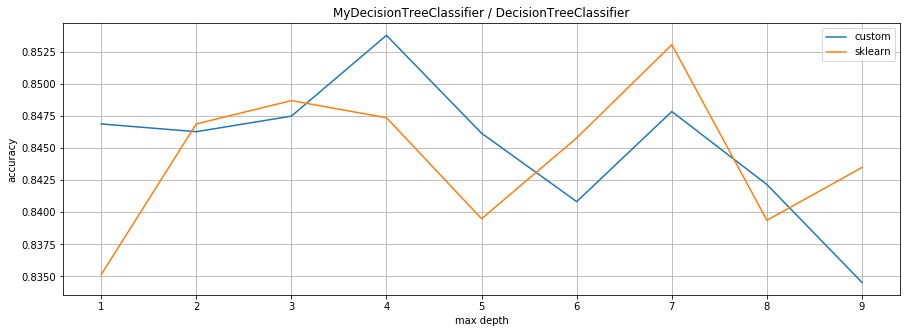

In [197]:
# Визуализируем влияние max_depth на accuracy:

fig = plt.figure(figsize=(15,5))
ax = plt.subplot()
ax.set_title('MyDecisionTreeClassifier / DecisionTreeClassifier')
ax.set_xlabel('max depth')
ax.set_ylabel('accuracy')
ax.grid()


# Модель построенная нами:

indx_max = table_of_results.query('model_owner == "custom"').accuracy_score.idxmax()
best_custom_model = table_of_results.iloc[[indx_max]]
best_sample_split = best_custom_model.min_sample_split.to_list()[0]
best_criterion = best_custom_model.criterion.to_list()[0]

sub_table_by_depth = table_of_results.query('model_owner == "custom" \
                                           & min_sample_split == @best_sample_split \
                                           & criterion == @best_criterion')

custom_graph = sub_table_by_depth.loc[:,['max_depth', 'accuracy_score']]\
                  .sort_values(by=['max_depth'])\
                  .set_index('max_depth')


# Модель из библиотеки scikit-learn:

indx_max = table_of_results.query('model_owner == "sklearn"').accuracy_score.idxmax()
best_custom_model = table_of_results.iloc[[indx_max]]
best_sample_split = best_custom_model.min_sample_split.to_list()[0]
best_criterion = best_custom_model.criterion.to_list()[0]

sub_table_by_depth = table_of_results.query('model_owner == "sklearn" \
                                           & min_sample_split == @best_sample_split \
                                           & criterion == @best_criterion')

sklearn_graph = sub_table_by_depth.loc[:,['max_depth', 'accuracy_score']]\
                  .sort_values(by=['max_depth'])\
                  .set_index('max_depth')

ax.plot(custom_graph, label='custom')
ax.plot(sklearn_graph, label='sklearn')

ax.legend()

plt.show();

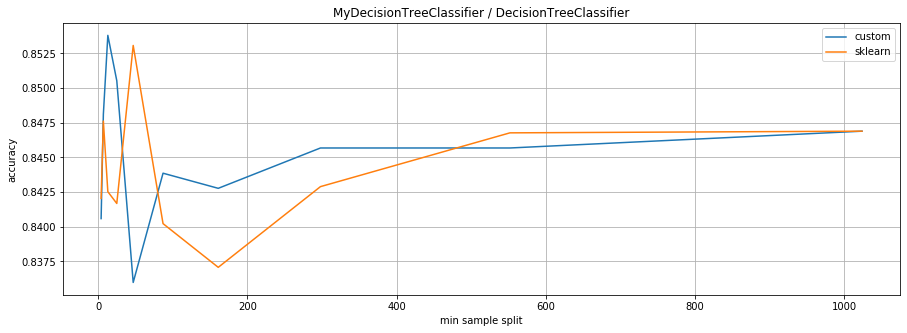

In [196]:
# Визуализируем влияние min_sample_split на accuracy:

fig = plt.figure(figsize=(15,5))
ax = plt.subplot()
ax.set_title('MyDecisionTreeClassifier / DecisionTreeClassifier')
ax.set_xlabel('min sample split')
ax.set_ylabel('accuracy')
ax.grid()


# Модель построенная нами:

indx_max = table_of_results.query('model_owner == "custom"').accuracy_score.idxmax()
best_custom_model = table_of_results.iloc[[indx_max]]
best_depth = best_custom_model.max_depth.to_list()[0]
best_criterion = best_custom_model.criterion.to_list()[0]

sub_table_by_depth = table_of_results.query('model_owner == "custom" \
                                           & max_depth == @best_depth \
                                           & criterion == @best_criterion')

custom_graph = sub_table_by_depth.loc[:,['min_sample_split', 'accuracy_score']]\
                  .sort_values(by=['min_sample_split'])\
                  .set_index('min_sample_split')


# Модель из библиотеки scikit-learn:

indx_max = table_of_results.query('model_owner == "sklearn"').accuracy_score.idxmax()
best_custom_model = table_of_results.iloc[[indx_max]]
best_depth = best_custom_model.max_depth.to_list()[0]
best_criterion = best_custom_model.criterion.to_list()[0]

sub_table_by_depth = table_of_results.query('model_owner == "sklearn" \
                                           & max_depth == @best_depth \
                                           & criterion == @best_criterion')

sklearn_graph = sub_table_by_depth.loc[:,['min_sample_split', 'accuracy_score']]\
                  .sort_values(by=['min_sample_split'])\
                  .set_index('min_sample_split')

ax.plot(custom_graph, label='custom')
ax.plot(sklearn_graph, label='sklearn')

ax.legend()

plt.show();

In [190]:
custom_index = table_of_results.query('model_owner == "custom"').accuracy_score.idxmax()
sklearn_index = table_of_results.query('model_owner == "sklearn"').accuracy_score.idxmax()
table_of_results.iloc[[custom_index, sklearn_index]]

,model_owner,max_depth,min_sample_split,criterion,accuracy_score
182,custom,4,13,gini,0.853800
203,sklearn,7,47,entropy,0.853073


## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве. 

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший. 
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева. 

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

In [191]:
my_clf = MyDecisionTreeClassifier(max_depth=4, min_samples_split=13, criterion='entropy')
clf    =   DecisionTreeClassifier(max_depth=7, min_samples_split=47, criterion='entropy')

In [192]:
my_clf.fit(X, y)
clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=7,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=47,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [193]:
# Важность признаков в дереве из sklearn:

args=clf.feature_importances_.argsort()
sklearn_features = np.array(df.drop(['match'],axis=1).columns.tolist())[args[::-1][:10]]
print("sklearn:", *sklearn_features)

sklearn: dec prob pid intel1_1 attr2_1 sinc2_1 fun race fun1_1 imprelig


In [194]:
# Важность признаков в custom дереве:

args=my_clf.feature_importances_.argsort()
custom_features = np.array(df.drop(['match'],axis=1).columns.tolist())[args[::-1][:10]]
print("custom:", *custom_features)

custom: intel3_1 dec intel2_1 attr2_1 from_Toronto, London, India imprelig sinc2_1 race prob pid


In [195]:
print("Доля совпадений: %.3f" % ((sklearn_features[...,np.newaxis] == custom_features[np.newaxis])\
                                 .sum()/sklearn_features.size))

Доля совпадений: 0.700


## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

Принцип суррогатов, при пропуске значений.

### ВАШ ОТЗЫВ ЗДЕСЬ



In [0]:
Всё вери гуд, ай дид лайк ит!